In [2]:
import numpy as np
from scipy.sparse import csr_matrix
#from numba import jit
from pickle import dump, load
import pandas as pd
from datetime import datetime

## Загрузка данных

In [3]:
train = np.loadtxt('data/train.txt',  delimiter="\t", dtype=int)

matrix = csr_matrix((train[:,2], (train[:,0]-1, train[:,1]-1))).toarray()

In [4]:
test = np.loadtxt('data/test.txt',  delimiter="\t", dtype=int)

max_user = max(test[:,0])
max_item = max(test[:,1])

matrix_test = np.zeros(matrix.shape, dtype=int)

for row in test:
    matrix_test[row[0]-1, row[1] -1] = 1


Разбиение на тренировочную и валидационную выборку

In [5]:
np.random.seed(42)
def split_dataset(matrix, ratio=0.1):

    # present elements
    pres_elements = np.arange(matrix.shape[0] * matrix.shape[1])[matrix.ravel() > 0]
    
    # size of test dataset
    test_size = int(ratio * pres_elements.shape[0])
    
    np.random.shuffle(pres_elements)
    
    train_el = pres_elements[test_size:]
    test_el = pres_elements[:test_size]
    
    train_ind = np.unravel_index(train_el, matrix.shape)
    test_ind = np.unravel_index(test_el, matrix.shape)
    
    
    train_mask = np.zeros(matrix.shape)
    test_mask = np.zeros(matrix.shape)
    
    for i in range(train_ind[0].shape[0]):
        train_mask[train_ind[0][i], train_ind[1][i]] = 1
    
    for i in range(test_ind[0].shape[0]):
        test_mask[test_ind[0][i], test_ind[1][i]] = 1
        
    return matrix * train_mask, matrix * test_mask

In [6]:
def create_submission(result, postfix):
    submission_name = ("data/submission_{}.txt".format(postfix))
    with open("data/test.txt", 'r') as input_file:
        with open(submission_name, 'w') as out_file:
            out_file.write("Id,Score\n")
            for id, line in enumerate(input_file):
                ui = [int(a) for a in line.strip().split('\t')]
                assert len(ui) == 2
                out_file.write("{},{}\n".format(id + 1, result[ui[0] - 1, ui[1] - 1]))

In [7]:
np.random.seed(42)
from matplotlib import pyplot as plt
class ImplicitALS:
    
    def __init__(self, max_epoch=10, embedding_size=15, alpha=10, lamdda=0.1, eps=0.1,
                  mean_decrease=0.85):

        self.max_epoch = max_epoch
        self.embedding_size = embedding_size
        self.alpha = alpha
        self.lamdda = lamdda
        self.eps = eps
        self.mean_decrease = mean_decrease

    def log_confidence(self, R_train):
        # 1 + alpha*log(1+r_ui/eps)
        return (np.ones(R_train.shape) + self.alpha * np.log(np.ones(R_train.shape) + R_train / self.eps))

    def normalisation(self, R, R_test):
        gr_mask = R > 0
        eq_mask = R == 0
        mean = R[gr_mask].mean()
        R_unbiased = R * gr_mask - gr_mask * mean
        user_bias = (R_unbiased.sum(1) / gr_mask.sum(1)).reshape(-1, 1)
        R_unuserbiased = R_unbiased * gr_mask - gr_mask * user_bias
        gr_mask_sum_0 = gr_mask.sum(0)
        gr_mask_sum_0[gr_mask_sum_0 == 0] = 1
        item_bias = (R_unuserbiased.sum(0) / gr_mask_sum_0).reshape(1, -1)

        gr_mask_test = R_test > 0
        P = R + eq_mask * (~gr_mask_test) * (user_bias + item_bias + mean) * self.mean_decrease + eq_mask * \
            gr_mask_test * (user_bias + item_bias + mean)
        #P  = (R > 0).astype(float)
        return P, mean, gr_mask, eq_mask

    def calc_loss(self, epoch, result, R_train, R_test, X, Y, C, gamma, beta, mean, gr_mask):

        train_error = np.sqrt(((result * gr_mask - R_train) ** 2).sum() / gr_mask.sum())

        R = R_train.copy()
        if R_test is not None:
            test_error = np.sqrt(((result * (R_test > 0) - R_test) ** 2).sum() / (R_test > 0).sum())
            R += R_test
        else:
            test_error = None

        metric = 1.0/(R.shape[0] * R.shape[1]) * \
                 (C * (R - beta - gamma - result) ** 2).sum() + \
                 self.lamdda * ((X**2).sum() + (Y**2).sum() + (beta**2).sum() + (gamma**2).sum())
        out = 'Epoch {}\ttrain {}\ttest {}\tloss {}'.format(epoch, train_error, test_error, metric)
        print(out)
        return train_error, test_error, metric

    def fit(self, R_train, R_test=None):

        tr_loss = []
        te_loss = []
        losses = []
        P, mean, gr_mask, eq_mask = self.normalisation(R_train, R_test)

        # x_u = (Y.T*Cu*Y + lambda*I)^(-1)*Y.T*Cu*p(u)
        C = self.log_confidence(R_train, R_test)

        laI = np.eye(self.embedding_size + 1, self.embedding_size + 1) * self.lamdda  # fixed

        # Initialize embeddings
        # embedding for user
        X = np.hstack([np.ones((R_train.shape[0], 1)), np.random.random_sample((R_train.shape[0], self.embedding_size))])
        # embedding for item
        Y = np.hstack([np.ones((R_train.shape[1], 1)), np.random.random_sample((R_train.shape[1], self.embedding_size))])

        # Initialize biases
        beta = np.zeros((X.shape[0], 1))  # user bias
        gamma = np.zeros((X.shape[0], 1))  # item bias


        n_user = (R_train + R_test > 0).sum(1)
        n_item = (R_train + R_test > 0).sum(0)


        for epoch in range(self.max_epoch):

            # User
            Pgamma = P - gamma
            Cp = C * Pgamma
            for i in range(X.shape[0]): # iterating over users
                # Y.T*Cu*Y + lambda*I
                YTCuY_laI = np.dot(C[i,:] * Y.T, Y) + laI * (n_user[i]) 
                # (Y.T*Cu*Y + lambda*I)^(-1)
                YTCuY_laI_inv = np.linalg.inv(YTCuY_laI)
                # (Y.T*Cu*Y + lambda*I)^(-1)*Y.T
                YTCuY_laI_inv_YT = np.matmul(YTCuY_laI_inv, Y.T)
                # x_u = (Y.T*Cu*Y + lambda*I)^(-1)*Y.T*Cu*p(u)
                X[i, :] = np.matmul(YTCuY_laI_inv_YT, Cp[i, :].reshape(-1, 1)).ravel()

            # Item
            beta = X[:, 0].copy().reshape(-1, 1)
            X[:, 0] = 1
            Pbeta = P - beta
            Cp = C * Pbeta
            for j in range(Y.shape[0]):  # iterating over items
                
                XTCuX_laI = np.dot(C[:,j] * X.T, X) + laI * (n_item[j]) 
                XTCuX_laI_inv = np.linalg.inv(XTCuX_laI)
                XTCuX_laI_inv_XT = np.matmul(XTCuX_laI_inv, X.T)
                Y[j, :] = np.matmul(XTCuX_laI_inv_XT, Cp[:, j].reshape(-1, 1)).ravel()

            gamma = Y[:, 0].copy().reshape(1, -1)
            Y[:, 0] = 1
            current_result = np.matmul(X[:, 1:], Y[:, 1:].T) + beta + gamma
            current_result_new = current_result.copy()

            current_result_new[current_result_new > 5] = 5
            current_result_new[current_result_new < 1] = 1
            
            
            
            train_error, test_error, loss = self.calc_loss(epoch, current_result_new, R_train, R_test, X, Y, C,
                              gamma, beta, mean,  gr_mask)
            
            tr_loss.append(train_error)
            te_loss.append(test_error)
            losses.append(loss)

        plt.plot(losses)
        return epoch_result_fix, tr_loss, te_loss

In [8]:
matrix = np.load("data/train_matrix.npy")

In [9]:
matrix_test = np.load("data/test_matrix.npy")

In [10]:
matrix_train, matrix_valid = split_dataset(matrix, 0.1)

[[5.         3.         4.         ... 2.15125521 3.07225451 2.74419151]
 [4.         2.95830471 2.84466103 ... 2.27615979 3.19715909 2.86909609]
 [2.72353258 2.24353198 2.1298883  ... 1.56138707 2.48238636 2.15432336]
 ...
 [5.         3.02913804 2.91549436 ... 2.34699313 3.26799242 2.93992942]
 [3.90950096 3.42950036 3.31585668 ... 2.74735545 3.66835474 3.34029174]
 [3.13434961 5.         2.54070533 ... 1.9722041  2.89320339 2.5651404 ]]
Epoch 0	train 0.8900169082371671	test 2.598762980077173	loss 25494.62104720031
Epoch 1	train 0.8332607060281829	test 2.6221296362515445	loss 24135.917188622545
Epoch 2	train 0.8103717983125533	test 2.6339860212328574	loss 23415.880945646102
Epoch 3	train 0.7974301917745269	test 2.6411251709008474	loss 22949.406907705234
Epoch 4	train 0.790628427939951	test 2.6447321365369563	loss 22603.868850549145
Epoch 5	train 0.7872654633547074	test 2.645826804730776	loss 22329.363306926898
Epoch 6	train 0.7855094259080061	test 2.645589098608668	loss 22105.7006521

Epoch 0	train 0.9018531878997423	test 2.57982375852433	loss 50487.57612730747
Epoch 1	train 0.8324129235023091	test 2.59703881857627	loss 51038.5569444069
Epoch 2	train 0.8093090672551224	test 2.6024417827249295	loss 50961.29750375848
Epoch 3	train 0.80114110725523	test 2.603502914299736	loss 50635.220047588366
Epoch 4	train 0.7969950759988891	test 2.603839952437083	loss 50301.887529335094
Epoch 5	train 0.79441024554452	test 2.604223563539405	loss 50014.04592131051
Epoch 6	train 0.7926762730800964	test 2.6046657299116536	loss 49772.705640437496
Epoch 7	train 0.7914938382229724	test 2.605079335166756	loss 49570.66626757011
Epoch 8	train 0.790671938038522	test 2.6054277008738835	loss 49401.95667876336
Epoch 9	train 0.7900825573020837	test 2.605660046942231	loss 49261.84015686835
Epoch 10	train 0.7896442281897936	test 2.6057529596836706	loss 49145.99150752503
Epoch 11	train 0.7893047476648718	test 2.605708702476335	loss 49050.61873753576
Epoch 12	train 0.7890306030705132	test 2.6055614096

Epoch 1	train 0.8537907764111361	test 2.56743159411643	loss 70865.10465490136
Epoch 2	train 0.8226691392914632	test 2.5741909695183653	loss 71817.69328594119
Epoch 3	train 0.8115982463538104	test 2.5765777847397207	loss 71838.94106795768
Epoch 4	train 0.8065339170539378	test 2.5773476504096986	loss 71704.36639488
Epoch 5	train 0.8036594584320187	test 2.577444260049688	loss 71571.48205298209
Epoch 6	train 0.8018215160611224	test 2.5772128963612086	loss 71469.16118616519
Epoch 7	train 0.8006078441166276	test 2.5768062852847535	loss 71397.4680911717
Epoch 8	train 0.7998059455687343	test 2.5762735795567235	loss 71352.08058767593
Epoch 9	train 0.7992714843326474	test 2.5756504870277617	loss 71328.9328988639
Epoch 10	train 0.7989059501943203	test 2.574971524485997	loss 71324.55823470738
Epoch 11	train 0.7986472009166189	test 2.5742577064627628	loss 71335.73071018666
Epoch 12	train 0.7984588474719571	test 2.57352252349755	loss 71359.21747015763
Epoch 13	train 0.7983193169034406	test 2.5727923

Epoch 2	train 0.7883749505130885	test 2.648950009154024	loss 25084.73897218342
Epoch 3	train 0.7785514395240027	test 2.650192497211982	loss 24490.699662883428
Epoch 4	train 0.7723971757022275	test 2.6509645458885096	loss 24040.776782433764
Epoch 5	train 0.7683921444581213	test 2.651466874997206	loss 23690.78972359637
Epoch 6	train 0.7658559353423778	test 2.651617079641848	loss 23411.897505346296
Epoch 7	train 0.7642411636135048	test 2.651482857505767	loss 23184.393475870078
Epoch 8	train 0.7631634555084278	test 2.6512544879057485	loss 22994.169000400976
Epoch 9	train 0.7624057314361685	test 2.651090091459157	loss 22831.074125782125
Epoch 10	train 0.7618512998794472	test 2.651022649523337	loss 22688.167912631114
Epoch 11	train 0.7614324461376196	test 2.6510615863134803	loss 22561.064373141915
Epoch 12	train 0.7611056232966806	test 2.651171053467441	loss 22446.877949406226
Epoch 13	train 0.7608449825460216	test 2.6513159905189716	loss 22343.52912897717
Epoch 14	train 0.7606340954701873	t

Epoch 2	train 0.7899347272987671	test 2.619241910670937	loss 52385.135945804504
Epoch 3	train 0.7806103305405787	test 2.621483657754829	loss 52251.970875216655
Epoch 4	train 0.7751605800699621	test 2.6214974771601205	loss 52092.439307097324
Epoch 5	train 0.7716466411630644	test 2.6210845496132187	loss 51938.321457941835
Epoch 6	train 0.769332463871981	test 2.6206991216661812	loss 51795.8196290261
Epoch 7	train 0.767806510439049	test 2.620359374417711	loss 51664.63160975047
Epoch 8	train 0.7667864127916547	test 2.6200325294751874	loss 51546.12367076812
Epoch 9	train 0.7660833772996524	test 2.6197101360821544	loss 51441.68362125144
Epoch 10	train 0.7655845175893454	test 2.619413227865819	loss 51351.39178802276
Epoch 11	train 0.7652225511099363	test 2.619125442149559	loss 51274.398795637055
Epoch 12	train 0.7649554471069427	test 2.6188333303408524	loss 51209.49630018584
Epoch 13	train 0.7647550239043781	test 2.618551523235199	loss 51155.37403222197
Epoch 14	train 0.7646025928943242	test 2

Epoch 3	train 0.8114513787530495	test 2.612575069706995	loss 76020.56667887194
Epoch 4	train 0.8078565589357602	test 2.612915375107532	loss 75348.56756588386
Epoch 5	train 0.8058980855045863	test 2.6131065896709855	loss 74755.35018060265
Epoch 6	train 0.8047142401835344	test 2.6131586318539237	loss 74248.59459362198
Epoch 7	train 0.8039172517957165	test 2.6131369188768026	loss 73826.0898073837
Epoch 8	train 0.8033287752878252	test 2.6130563677620553	loss 73479.43870315915
Epoch 9	train 0.8028730193282192	test 2.6128857950567945	loss 73199.05628686138
Epoch 10	train 0.8025096374169056	test 2.612595817397411	loss 72975.5189926287
Epoch 11	train 0.8022212023106428	test 2.6121942940371143	loss 72798.69899568174
Epoch 12	train 0.8020025595197342	test 2.611705684928526	loss 72659.22227116766
Epoch 13	train 0.8018434466202236	test 2.611165021477182	loss 72550.60429541985
Epoch 14	train 0.8017283841340475	test 2.610603370048421	loss 72467.81395404843
Epoch 15	train 0.8016470847345605	test 2.61

Epoch 4	train 0.7557941174133467	test 2.6501375681933705	loss 24562.42144220284
Epoch 5	train 0.7520857342250188	test 2.6525070280679883	loss 24224.96217055055
Epoch 6	train 0.7496180029115316	test 2.654858342376843	loss 23976.624548040192
Epoch 7	train 0.7478616036498603	test 2.656950686884339	loss 23783.618728689755
Epoch 8	train 0.7465410591578191	test 2.6587174325713043	loss 23627.086523766062
Epoch 9	train 0.7454911461403241	test 2.660172649207437	loss 23496.012700827177
Epoch 10	train 0.7446248649555758	test 2.661334012213737	loss 23383.12990656384
Epoch 11	train 0.7439011206291842	test 2.662211345515739	loss 23283.23512864454
Epoch 12	train 0.7433037682231596	test 2.6628421313629285	loss 23192.776039406115
Epoch 13	train 0.7428130888861141	test 2.663293538943881	loss 23109.556418169395
Epoch 14	train 0.7424057410978067	test 2.663599529385821	loss 23032.24364474541
Epoch 15	train 0.7420602367047099	test 2.6637819247217283	loss 22960.055130829205
Epoch 16	train 0.741758822897839	t

Epoch 5	train 0.7910865377876126	test 2.6414190861289057	loss 54066.915860210276
Epoch 6	train 0.7887975726492088	test 2.6415877626382214	loss 53612.0676007254
Epoch 7	train 0.7873042076981138	test 2.6417029237789658	loss 53224.21515219211
Epoch 8	train 0.7863151979687745	test 2.641851489738817	loss 52894.167680833314
Epoch 9	train 0.7856733332248531	test 2.6419566750556394	loss 52607.31947965521
Epoch 10	train 0.7852641005818907	test 2.641968415989679	loss 52353.52887671588
Epoch 11	train 0.785003848648921	test 2.6418909658104184	loss 52127.84087360737
Epoch 12	train 0.7848354343576595	test 2.6417492867407546	loss 51927.633746411855
Epoch 13	train 0.7847238585877372	test 2.641560031068752	loss 51750.9499517018
Epoch 14	train 0.7846472590137612	test 2.6413393039716193	loss 51595.705541997995
Epoch 15	train 0.7845931293662691	test 2.641088092137833	loss 51459.77091211362
Epoch 16	train 0.7845528358815624	test 2.640812539624056	loss 51341.11114687442
Epoch 17	train 0.7845223931271714	tes

Epoch 6	train 0.7864909309208642	test 2.6269184551850193	loss 76857.24032394149
Epoch 7	train 0.7848604286505807	test 2.627092941430257	loss 76494.75163019671
Epoch 8	train 0.7836479287225079	test 2.62700346588524	loss 76197.24215859752
Epoch 9	train 0.782767274313078	test 2.62667101119851	loss 75955.15150784478
Epoch 10	train 0.7821429287701211	test 2.6261472847501732	loss 75757.96510425129
Epoch 11	train 0.7817063079607043	test 2.625505456921247	loss 75597.21497547964
Epoch 12	train 0.7813967983666751	test 2.6248086927730725	loss 75466.91594469821
Epoch 13	train 0.7811671798057841	test 2.6241070106960915	loss 75362.68641845947
Epoch 14	train 0.7809845501161667	test 2.623421217535463	loss 75280.97756601938
Epoch 15	train 0.780827563163606	test 2.6227648898601212	loss 75218.71262714855
Epoch 16	train 0.7806829042311226	test 2.6221451274871455	loss 75173.17462166348
Epoch 17	train 0.7805433079731852	test 2.6215628964391158	loss 75141.97372327032
Epoch 18	train 0.7804053799819303	test 2.

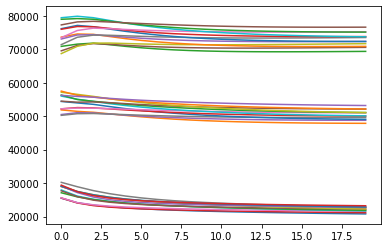

In [35]:
results = []

alphas = [25, 30, 35, 40]
embedding_sizes = [5,6,7]
lamddas = [2, 5, 7.5]

for alph in alphas:
    for emb_size in embedding_sizes:
        for lam in lamddas:
            model = ImplicitALS(max_epoch=20,
                    embedding_size=emb_size,
                    alpha=alph,
                    lamdda=lam,
                    eps=.11,
                    mean_decrease=0.85)
            res, _, _ = model.fit(matrix, matrix_test)
            results.append(res)


In [36]:
# 0.91375
final_result = np.zeros(results[0].shape)
for r in results:
    final_result = final_result + r
final_result = final_result/len(results)
create_submission(final_result, 'stacking'+str(len(results)))

25 5 2 0.07
[[5.         3.         4.         ... 2.15125521 3.07225451 2.74419151]
 [4.         2.95830471 2.84466103 ... 2.27615979 3.19715909 2.86909609]
 [2.72353258 2.24353198 2.1298883  ... 1.56138707 2.48238636 2.15432336]
 ...
 [5.         3.02913804 2.91549436 ... 2.34699313 3.26799242 2.93992942]
 [3.90950096 3.42950036 3.31585668 ... 2.74735545 3.66835474 3.34029174]
 [3.13434961 5.         2.54070533 ... 1.9722041  2.89320339 2.5651404 ]]
Epoch 0	train 0.8887386880825847	test 2.604478683339609	loss 26499.89468141328
Epoch 1	train 0.8349096412063775	test 2.6210072061550673	loss 24974.642678204847
Epoch 2	train 0.8136523206710984	test 2.631755496225491	loss 24062.64935800662
Epoch 3	train 0.8016195251005276	test 2.6378245839490853	loss 23549.75381178546
Epoch 4	train 0.794775241097506	test 2.639923774092651	loss 23223.649832788375
Epoch 5	train 0.7907518561712875	test 2.6404896609376145	loss 22977.663417732063
Epoch 6	train 0.788065182227253	test 2.6406971323988464	loss 2277

Epoch 0	train 0.9062895832756103	test 2.5725582616202773	loss 51042.8301784692
Epoch 1	train 0.8492830608129804	test 2.589699430830724	loss 51514.56051270131
Epoch 2	train 0.827161053252645	test 2.59655014441025	loss 51370.87771586301
Epoch 3	train 0.8169907521656112	test 2.599607348290036	loss 50914.555778729235
Epoch 4	train 0.8107546290835425	test 2.6014916534761694	loss 50446.04902259507
Epoch 5	train 0.8070722026718202	test 2.603100707630563	loss 50003.776093402135
Epoch 6	train 0.8049924631849221	test 2.604419548112717	loss 49605.38868036572
Epoch 7	train 0.8038032178473439	test 2.6054436310618163	loss 49261.978205000385
Epoch 8	train 0.8031095620322743	test 2.606209516521274	loss 48975.37931928028
Epoch 9	train 0.8027066240111013	test 2.606735106957791	loss 48739.94722897951
Epoch 10	train 0.8024824445663868	test 2.6070409763640106	loss 48547.09917193477
Epoch 11	train 0.8023648025307315	test 2.6071583981628907	loss 48389.700314372545
Epoch 12	train 0.8023080858739104	test 2.607

Epoch 0	train 0.9186370515858772	test 2.5541889125847264	loss 69820.22958502201
Epoch 1	train 0.8813078520839527	test 2.576179630207101	loss 70003.1895463889
Epoch 2	train 0.8533927476701375	test 2.583123996844028	loss 70476.48166980258
Epoch 3	train 0.8391480408333338	test 2.5842402839360963	loss 70189.32452135065
Epoch 4	train 0.8334610816415379	test 2.5824045513439993	loss 69776.82261604705
Epoch 5	train 0.8308046073217907	test 2.580542380548905	loss 69397.94962541542
Epoch 6	train 0.8295012388153888	test 2.5789862281074614	loss 69080.12358292562
Epoch 7	train 0.8288590837964576	test 2.57761676429201	loss 68832.36368332357
Epoch 8	train 0.8285115384013649	test 2.576349205360539	loss 68652.98867414374
Epoch 9	train 0.8282795389069987	test 2.5751382500517583	loss 68532.13022344375
Epoch 10	train 0.8280829828437388	test 2.573963668395044	loss 68458.16140467771
Epoch 11	train 0.8278899152561044	test 2.572810621241502	loss 68420.49398356568
Epoch 12	train 0.8276941704155433	test 2.571687

Epoch 0	train 0.8960399049450072	test 2.588331684138581	loss 51560.256450620676
Epoch 1	train 0.8286756398306546	test 2.5999786335977353	loss 51980.009715473294
Epoch 2	train 0.803205272920898	test 2.6064102171406054	loss 51771.853122134096
Epoch 3	train 0.7938345763942218	test 2.60776899990756	loss 51438.06629753961
Epoch 4	train 0.7895279141164534	test 2.608117093953376	loss 51137.72983683561
Epoch 5	train 0.7872035320932264	test 2.6084117020350965	loss 50870.83521777837
Epoch 6	train 0.7857673667686693	test 2.6087787715236437	loss 50635.37730268386
Epoch 7	train 0.7847513933920655	test 2.6091803378126537	loss 50430.985879851614
Epoch 8	train 0.7839494021580243	test 2.6095883344591138	loss 50256.7952228175
Epoch 9	train 0.7832702297944703	test 2.6100023048062457	loss 50111.28302250172
Epoch 10	train 0.7826877153844372	test 2.6103751115783576	loss 49991.591801225026
Epoch 11	train 0.7822020484429058	test 2.610667469385197	loss 49894.236771184536
Epoch 12	train 0.7818098610438228	test 

Epoch 0	train 0.914818106592528	test 2.5502206573228245	loss 70045.55034456651
Epoch 1	train 0.8599354773236422	test 2.572763723023957	loss 71245.36048923356
Epoch 2	train 0.8304664086067177	test 2.5813253899695567	loss 71848.02495955814
Epoch 3	train 0.8198470385606418	test 2.5831237926930792	loss 71682.19881142203
Epoch 4	train 0.8152067773371839	test 2.5820066686173306	loss 71376.95194096696
Epoch 5	train 0.8125726213962764	test 2.5804899993918227	loss 71088.48693259122
Epoch 6	train 0.8108429125416629	test 2.5791645204806946	loss 70856.1192978208
Epoch 7	train 0.8096451312417243	test 2.5781079878378743	loss 70683.78853959775
Epoch 8	train 0.808816309915227	test 2.5772728611944564	loss 70562.969656158
Epoch 9	train 0.8082583309040988	test 2.5765950789575043	loss 70482.72951563096
Epoch 10	train 0.8078971712627276	test 2.5760127504657673	loss 70433.57537440099
Epoch 11	train 0.807674938170525	test 2.5754731261486614	loss 70408.04885850164
Epoch 12	train 0.8075476285776555	test 2.5749

Epoch 0	train 0.8867892708290327	test 2.6123029773444784	loss 26413.49878303983
Epoch 1	train 0.824429013227273	test 2.6316168141999237	loss 25103.78962435088
Epoch 2	train 0.8029171060090524	test 2.6432351115421002	loss 24231.381662048454
Epoch 3	train 0.795010607045371	test 2.6468701244245265	loss 23658.723511230088
Epoch 4	train 0.7911432151283654	test 2.6479385160890967	loss 23252.16558946752
Epoch 5	train 0.7887223222001758	test 2.648468152598778	loss 22940.787878299663
Epoch 6	train 0.7870107191006652	test 2.648920950820556	loss 22689.22228857946
Epoch 7	train 0.7857307257974745	test 2.6493665691596533	loss 22479.144539188845
Epoch 8	train 0.7847534113304607	test 2.6497362950744736	loss 22299.087453891425
Epoch 9	train 0.7840191098883754	test 2.6499202475938843	loss 22140.909005055833
Epoch 10	train 0.7834758595258925	test 2.6499444025750254	loss 22000.461057445824
Epoch 11	train 0.783077874930328	test 2.6498988134402737	loss 21874.686058848874
Epoch 12	train 0.7827905631923252	t

Epoch 0	train 0.903832066440143	test 2.5800587191288717	loss 75216.64130951588
Epoch 1	train 0.8417920984607224	test 2.6002058665591132	loss 76223.61672415852
Epoch 2	train 0.8213658940673427	test 2.6051225424388056	loss 75901.69231714061
Epoch 3	train 0.8139759873404855	test 2.6053642127998726	loss 75249.5936507001
Epoch 4	train 0.8103623168234172	test 2.6048487240359175	loss 74634.88086887149
Epoch 5	train 0.8082330315102697	test 2.6044834685833695	loss 74112.48541003448
Epoch 6	train 0.8068151195617635	test 2.60425375814219	loss 73678.7033527494
Epoch 7	train 0.8058022602588162	test 2.60401078990707	loss 73315.68304198743
Epoch 8	train 0.8050452882118418	test 2.603738298942055	loss 73010.7217554142
Epoch 9	train 0.804449821662209	test 2.6034348715653026	loss 72758.92797015539
Epoch 10	train 0.8039781387933427	test 2.603110148308611	loss 72554.54123398614
Epoch 11	train 0.8036109532445762	test 2.6027647161588185	loss 72391.50562628682
Epoch 12	train 0.8033267230080192	test 2.60239807

Epoch 0	train 0.8759478481350571	test 2.6205663466991806	loss 28075.57290534256
Epoch 1	train 0.809919056335973	test 2.6472337931898666	loss 26062.64216959457
Epoch 2	train 0.7884059750374101	test 2.6569880158133725	loss 24903.270524672003
Epoch 3	train 0.7789143322914337	test 2.6594242338577194	loss 24140.040783557368
Epoch 4	train 0.77387069190519	test 2.6592851991729205	loss 23610.693616730172
Epoch 5	train 0.7707542735167526	test 2.6586329883199484	loss 23230.466572350353
Epoch 6	train 0.7685619720577657	test 2.6579423254450214	loss 22950.517631570314
Epoch 7	train 0.7668792111823868	test 2.6573516841427707	loss 22739.591349832834
Epoch 8	train 0.7655292853294818	test 2.6568539985617283	loss 22575.696551936115
Epoch 9	train 0.7644062458136324	test 2.6563919808193837	loss 22443.816905632666
Epoch 10	train 0.7634611796057863	test 2.655988822426964	loss 22333.76454987778
Epoch 11	train 0.762670814474872	test 2.6556419238212823	loss 22238.703014801442
Epoch 12	train 0.762025735055649	t

Epoch 0	train 0.900667857802043	test 2.5919709043099664	loss 52714.54054365814
Epoch 1	train 0.8338213066305549	test 2.602601937818535	loss 52417.71284248522
Epoch 2	train 0.8099527842680694	test 2.609998977220357	loss 52189.669059212385
Epoch 3	train 0.8002088081678738	test 2.6138350407491546	loss 51782.49849717271
Epoch 4	train 0.7949423135175246	test 2.616439588757537	loss 51402.06631292291
Epoch 5	train 0.7917931565588919	test 2.6185037315911637	loss 51073.58188190404
Epoch 6	train 0.789811810067362	test 2.6200784251979825	loss 50788.25904704188
Epoch 7	train 0.7884531682087503	test 2.6210899582272664	loss 50540.03371103425
Epoch 8	train 0.7874290198567552	test 2.621599509911368	loss 50325.218675234544
Epoch 9	train 0.7865955600155858	test 2.6217317443253685	loss 50140.77007113992
Epoch 10	train 0.78589066146777	test 2.621604480445161	loss 49983.63876955603
Epoch 11	train 0.7852931244785047	test 2.6213324965745146	loss 49850.9157814082
Epoch 12	train 0.7847917138185556	test 2.62097

Epoch 0	train 0.883312911367324	test 2.625554510031432	loss 29068.872622107683
Epoch 1	train 0.827320344207001	test 2.642015749337882	loss 27840.995656886003
Epoch 2	train 0.8031398807532762	test 2.6539227638373153	loss 26910.78597379798
Epoch 3	train 0.7922742662685813	test 2.6594743104693728	loss 26176.17822943586
Epoch 4	train 0.786430023090293	test 2.661885866141105	loss 25574.18609770289
Epoch 5	train 0.7824926729820288	test 2.663272312135819	loss 25085.671990986306
Epoch 6	train 0.7797216375024569	test 2.664198370200613	loss 24691.27455016394
Epoch 7	train 0.7778755142707274	test 2.664730478198125	loss 24368.077692495266
Epoch 8	train 0.7766460474409632	test 2.664940534963266	loss 24097.918131929495
Epoch 9	train 0.7757970499850141	test 2.6650052969027755	loss 23867.11317717971
Epoch 10	train 0.7751824095025046	test 2.6649999860241644	loss 23665.76104093105
Epoch 11	train 0.774733000236751	test 2.664873079529216	loss 23486.993434957618
Epoch 12	train 0.7744055945523513	test 2.664

Epoch 0	train 0.8990350090553411	test 2.615853183669516	loss 56470.292505699756
Epoch 1	train 0.8362509161105874	test 2.624166715142529	loss 55563.49034518179
Epoch 2	train 0.8132833792963016	test 2.6323377555770975	loss 54845.86677070888
Epoch 3	train 0.8039234290346244	test 2.634214811564964	loss 54108.962246733136
Epoch 4	train 0.7993730681201033	test 2.6334336206706848	loss 53472.6703869614
Epoch 5	train 0.7966817996676775	test 2.6321297613411403	loss 52932.5733099015
Epoch 6	train 0.7947392510231059	test 2.6311327802270106	loss 52476.21543111898
Epoch 7	train 0.7932092280876929	test 2.63070109010394	loss 52086.25139715965
Epoch 8	train 0.7920209036657693	test 2.630715977879208	loss 51751.02088924551
Epoch 9	train 0.7911370670372901	test 2.6309470130976966	loss 51463.60197670888
Epoch 10	train 0.7905086471916167	test 2.6312188582856986	loss 51216.93864194599
Epoch 11	train 0.7900709134599934	test 2.631456506920809	loss 51004.38018651824
Epoch 12	train 0.7897631457054679	test 2.6316

Epoch 0	train 0.9124348419505728	test 2.5894259438489673	loss 75063.09877918275
Epoch 1	train 0.8609491930333757	test 2.603227871649262	loss 75493.0022263969
Epoch 2	train 0.8332210355709802	test 2.610246894506572	loss 75311.26042604161
Epoch 3	train 0.8226231079952421	test 2.6124068115012786	loss 74610.24473230935
Epoch 4	train 0.8180598039923874	test 2.6124499194498685	loss 73928.98788619244
Epoch 5	train 0.8155306110614634	test 2.612023336007585	loss 73344.28352031461
Epoch 6	train 0.8139470755979287	test 2.611448839992046	loss 72864.01020821389
Epoch 7	train 0.8128875473951176	test 2.610781194094935	loss 72477.73010638832
Epoch 8	train 0.812135564612832	test 2.6100500987908664	loss 72171.36322822949
Epoch 9	train 0.8115723042102627	test 2.609273901837988	loss 71930.37924432622
Epoch 10	train 0.8111266557110545	test 2.608447812288501	loss 71742.67314470313
Epoch 11	train 0.810750334860169	test 2.6075877253569653	loss 71598.89453950398
Epoch 12	train 0.8104130423384701	test 2.6067127

Epoch 0	train 0.8907253228230444	test 2.602047887888782	loss 55142.836969012984
Epoch 1	train 0.8165850926280825	test 2.6240449557854575	loss 55051.28604323496
Epoch 2	train 0.791893975689071	test 2.634903714315512	loss 54887.19152547673
Epoch 3	train 0.7824915196891341	test 2.6385290900142118	loss 54610.468128901615
Epoch 4	train 0.7776411295256589	test 2.639539660546843	loss 54290.66224763608
Epoch 5	train 0.7746407537618775	test 2.639435212947017	loss 53980.00541183585
Epoch 6	train 0.7726137515941343	test 2.6390102020901973	loss 53693.062521857784
Epoch 7	train 0.7711659928200135	test 2.6385703062279586	loss 53433.19230420001
Epoch 8	train 0.7700922311384083	test 2.638241750295373	loss 53199.48699940453
Epoch 9	train 0.7692808559408031	test 2.638005171970645	loss 52990.25522557538
Epoch 10	train 0.7686559142931151	test 2.6378205793679803	loss 52805.578869459
Epoch 11	train 0.7681685696986691	test 2.637671605908561	loss 52645.1702599971
Epoch 12	train 0.7677831743939338	test 2.63753

Epoch 0	train 0.9031717143131449	test 2.580626953895002	loss 74372.16150255842
Epoch 1	train 0.8421971068899328	test 2.5956485681257453	loss 76058.81862365313
Epoch 2	train 0.8156781986662657	test 2.601158233204892	loss 76236.97305629257
Epoch 3	train 0.8046688103110796	test 2.603868247746365	loss 75905.287077161
Epoch 4	train 0.7986433282290014	test 2.6051083884281776	loss 75519.13691902164
Epoch 5	train 0.7948498982065294	test 2.6059102084576837	loss 75165.23787972268
Epoch 6	train 0.79240161247031	test 2.6063476676273103	loss 74856.92766698197
Epoch 7	train 0.7907907222173985	test 2.6064993921174295	loss 74599.65172491994
Epoch 8	train 0.7896723177021918	test 2.6065144957534025	loss 74390.8056193773
Epoch 9	train 0.7888487371982694	test 2.606481473887894	loss 74222.85505115174
Epoch 10	train 0.7882152518740388	test 2.6064434766308	loss 74088.09738460921
Epoch 11	train 0.7877134014422129	test 2.6064397006278512	loss 73981.20671789319
Epoch 12	train 0.7873070896685896	test 2.606472298

Epoch 0	train 0.8825873298561909	test 2.6484016960907617	loss 28605.063687102374
Epoch 1	train 0.8251035548894642	test 2.658939737480564	loss 26976.81525904914
Epoch 2	train 0.8019012522108402	test 2.6678568709674444	loss 26002.032857202452
Epoch 3	train 0.7919621248643977	test 2.6724158082952116	loss 25322.15665175652
Epoch 4	train 0.7870466862037615	test 2.6732370321798435	loss 24814.770085902288
Epoch 5	train 0.7841415379697837	test 2.672696308311666	loss 24411.752614085828
Epoch 6	train 0.7821640165730793	test 2.671780895082908	loss 24081.19826478801
Epoch 7	train 0.7807276415034822	test 2.6709039594619233	loss 23805.31167285419
Epoch 8	train 0.7796526540999315	test 2.6702031209769235	loss 23571.742411480605
Epoch 9	train 0.7788339136364707	test 2.6697043237131846	loss 23371.394678688466
Epoch 10	train 0.7782026013834812	test 2.6693279055291765	loss 23197.172336417836
Epoch 11	train 0.7777105047909028	test 2.6690120143655447	loss 23043.56347569504
Epoch 12	train 0.7773287028147007	

Epoch 0	train 0.9014709584631043	test 2.6001783658657245	loss 79824.80327396606
Epoch 1	train 0.8410801386351671	test 2.6169254416952548	loss 80529.50733780743
Epoch 2	train 0.8171017802130308	test 2.6260069382171083	loss 79956.48254055413
Epoch 3	train 0.8080903517197068	test 2.6280335342497207	loss 79142.50751409067
Epoch 4	train 0.8036926772704183	test 2.6285559249338597	loss 78416.90428086964
Epoch 5	train 0.800715604938368	test 2.6291954744155595	loss 77783.99992760364
Epoch 6	train 0.7982583082916728	test 2.630051571087976	loss 77244.05571179673
Epoch 7	train 0.7961236638584386	test 2.630928833344654	loss 76794.56594929693
Epoch 8	train 0.79435876442943	test 2.631687697745365	loss 76424.57708168203
Epoch 9	train 0.793005016771385	test 2.632189001080515	loss 76121.1238795425
Epoch 10	train 0.7920427240178968	test 2.6323775929479845	loss 75869.63477636453
Epoch 11	train 0.7914134977525791	test 2.632243286339249	loss 75656.9851513163
Epoch 12	train 0.7910275486822752	test 2.63187365

Epoch 0	train 0.8735434865672451	test 2.639693387146433	loss 29742.053513935807
Epoch 1	train 0.8140304721063392	test 2.647948447877401	loss 28253.703073087905
Epoch 2	train 0.7899658308044758	test 2.6569603289413664	loss 27168.86277452427
Epoch 3	train 0.7788788491720088	test 2.6610553693199144	loss 26361.087637267203
Epoch 4	train 0.7728723916914053	test 2.663517755983604	loss 25760.67194188555
Epoch 5	train 0.7688753196528642	test 2.6653557281231217	loss 25292.728537399777
Epoch 6	train 0.7658505245631507	test 2.6666886057730195	loss 24913.173524050933
Epoch 7	train 0.7634241193549173	test 2.66751712806551	loss 24597.12709074747
Epoch 8	train 0.7614974938480167	test 2.6678587065508883	loss 24330.47162703891
Epoch 9	train 0.7600175767111483	test 2.6679434102955324	loss 24103.874021586264
Epoch 10	train 0.7589078706406686	test 2.6679040601465815	loss 23909.633917753537
Epoch 11	train 0.7580822259226895	test 2.667799374635194	loss 23742.182764980604
Epoch 12	train 0.7574565099703999	te

Epoch 0	train 0.8933047432780651	test 2.6063003537156657	loss 54864.71929476939
Epoch 1	train 0.8237048314556871	test 2.6237875657973344	loss 54932.14368463108
Epoch 2	train 0.8006954198284647	test 2.631881895233568	loss 54570.01312400266
Epoch 3	train 0.7906613565267847	test 2.6347783215800233	loss 54112.391605988574
Epoch 4	train 0.7846055979788793	test 2.635413135005568	loss 53716.9107063252
Epoch 5	train 0.7805734302857081	test 2.635303877384165	loss 53389.334684105714
Epoch 6	train 0.777908817434317	test 2.635203204510752	loss 53109.02967092159
Epoch 7	train 0.7761131898650782	test 2.635304116598731	loss 52863.32451752924
Epoch 8	train 0.7748406263502448	test 2.635517240241981	loss 52643.5510182855
Epoch 9	train 0.7738874223559473	test 2.6357910015020054	loss 52445.2070269244
Epoch 10	train 0.7731479102558775	test 2.6360839307593618	loss 52266.35272588208
Epoch 11	train 0.772571619159773	test 2.636374096097564	loss 52105.93441256387
Epoch 12	train 0.7721245468271731	test 2.6366573

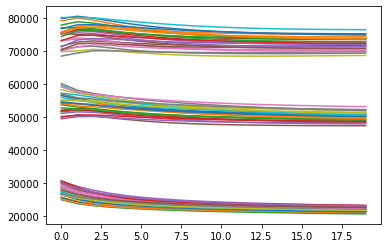

In [10]:
np.random.seed(32)
results = []

alphas = [25, 30, 35, 40]
embedding_sizes = [5, 6]
lamddas = [2, 5, 7.5]
eps = [0.07,0.11, 0.15]

for alph in alphas:
    for emb_size in embedding_sizes:
        for lam in lamddas:
            for e in eps:
                print(alph, emb_size, lam, e)
                model = ImplicitALS(max_epoch=20,
                        embedding_size=emb_size,
                        alpha=alph,
                        lamdda=lam,
                        eps=e,
                        mean_decrease=0.85)
                res, _, _ = model.fit(matrix, matrix_test)
                results.append(res)


In [11]:
# 0.91330
final_result = np.zeros(results[0].shape)
for r in results:
    final_result = final_result + r
final_result = final_result/len(results)
create_submission(final_result, 'stacking'+str(len(results)))

Лучшее решение

25 5 2 0.07
[[5.         3.         3.17661176 ... 2.12596045 3.04582588 2.70617784]
 [4.         2.93226605 2.84198268 ... 2.26782313 3.18768855 2.84804052]
 [2.75361042 2.26303942 2.17275604 ... 1.59859649 2.51846192 2.17881388]
 ...
 [5.         2.92595808 2.8356747  ... 2.26151515 3.18138058 2.84173254]
 [3.92254081 3.43196981 3.34168643 ... 2.76752688 3.68739231 3.34774427]
 [3.13121439 5.         2.55036001 ... 1.97620047 2.89606589 2.55641786]]
Epoch 0	train 0.8870579152220112	test 0.9728464925580894	loss 27455.459999169423
Epoch 1	train 0.8343412669941354	test 0.9599529800834126	loss 25540.364162709277
Epoch 2	train 0.8089396302085843	test 0.9483550520002618	loss 24421.797724132575
Epoch 3	train 0.7931711305954638	test 0.9368408934032698	loss 23713.893842964808
Epoch 4	train 0.784996305993516	test 0.9280913029112319	loss 23224.582049905563
Epoch 5	train 0.7807787916714903	test 0.9226060377059921	loss 22863.460940411558
Epoch 6	train 0.7782894617996975	test 0.9194241507694204	lo

Epoch 19	train 0.7896100286270064	test 0.8990008106001216	loss 48760.08070636758
25 5 5 0.11
[[5.         3.         4.         ... 2.14753788 3.0996308  2.70706522]
 [4.         2.93759917 2.79824114 ... 2.26148715 3.21358008 2.82101449]
 [2.73758467 2.26406656 2.12470853 ... 1.58795455 2.54004747 2.14748188]
 ...
 [5.         3.0361499  2.89679187 ... 2.36003788 3.3121308  2.91956522]
 [3.92117594 3.44765783 3.3082998  ... 2.77154582 3.72363874 3.33107315]
 [3.13791185 5.         2.52503571 ... 1.98828173 2.94037465 2.54780907]]
Epoch 0	train 0.9017353869623503	test 0.9587606262494183	loss 52635.63565462152
Epoch 1	train 0.8458413001517546	test 0.9371670581563384	loss 52058.030981922755
Epoch 2	train 0.8213500612533715	test 0.9217084781592269	loss 51657.276805081994
Epoch 3	train 0.8114315887928967	test 0.912258463354693	loss 51041.79943285041
Epoch 4	train 0.8069854048351716	test 0.9071172291682918	loss 50505.51757364714
Epoch 5	train 0.8045404063128441	test 0.9041102380472893	loss 

Epoch 19	train 0.8154542992140745	test 0.9043484572911864	loss 69640.42021027312
25 5 7.5 0.15
[[5.         3.         4.         ... 2.12959921 3.03899362 2.7357322 ]
 [4.         2.89210341 2.75329157 ... 2.22088164 3.13027605 2.82701463]
 [2.64696999 2.15398375 2.01517191 ... 1.48276198 2.39215639 2.08889497]
 ...
 [5.         3.2509923  3.11218045 ... 2.57977053 3.48916494 3.18590352]
 [3.88859659 3.39561035 3.25679851 ... 2.72438859 3.633783   3.33052157]
 [3.19373699 5.         2.56193891 ... 2.02952899 2.9389234  2.63566197]]
Epoch 0	train 0.9134883920573245	test 0.9486858394180422	loss 72012.34965538933
Epoch 1	train 0.8712808626108627	test 0.9251837092116489	loss 71331.13902989165
Epoch 2	train 0.8435743137167367	test 0.9109333547350273	loss 71280.79906933027
Epoch 3	train 0.83277287907533	test 0.9050769474848455	loss 70687.79326907033
Epoch 4	train 0.8281530002530874	test 0.9025335890204566	loss 70148.61698054247
Epoch 5	train 0.8256894712833167	test 0.9011879369140232	loss 6

Epoch 18	train 0.7623766420885031	test 0.8961931731695457	loss 20865.746574979155
Epoch 19	train 0.7622673934358386	test 0.8959051460395562	loss 20828.75343485144
25 6 5 0.07
[[5.         3.         4.         ... 2.22783251 3.12298137 2.77641558]
 [4.         2.99487371 2.85627708 ... 2.31291188 3.20806073 2.86149495]
 [2.72273968 2.26317781 2.12458117 ... 1.58121597 2.47636483 2.12979904]
 ...
 [5.         3.37265149 3.23405486 ... 2.69068966 3.58583851 3.23927273]
 [3.91455712 3.45499524 3.31639861 ... 2.77303341 3.66818226 3.32161648]
 [3.12445826 5.         2.52629976 ... 1.98293455 2.87808341 2.53151763]]
Epoch 0	train 0.8919495942904191	test 0.9530271924549387	loss 53025.3406265683
Epoch 1	train 0.8288157400725851	test 0.9376789100684386	loss 52313.5011824765
Epoch 2	train 0.8018211084382695	test 0.9247128070226714	loss 52004.26816530587
Epoch 3	train 0.7892902613636965	test 0.9169635861242417	loss 51663.281853819
Epoch 4	train 0.7831548407513875	test 0.9130713779010774	loss 513

Epoch 18	train 0.7946408632436426	test 0.900801895924029	loss 72047.79491176362
Epoch 19	train 0.7945246188391608	test 0.9009180869147521	loss 72080.22687449497
25 6 7.5 0.11
[[5.         3.32272662 4.         ... 2.15226975 3.04135021 2.73606852]
 [4.         2.98403125 2.84791566 ... 2.31198337 3.20106383 2.89578214]
 [2.71929784 2.2707723  2.1346567  ... 1.59872442 2.48780488 2.18252319]
 ...
 [5.         3.04130075 2.90518516 ... 2.36925287 3.25833333 2.95305164]
 [3.90568651 3.45716097 3.32104537 ... 2.78511309 3.67419355 3.36891186]
 [3.11686711 5.         2.53222598 ... 1.99629369 2.88537415 2.58009246]]
Epoch 0	train 0.9062442821212804	test 0.9499843687793776	loss 71167.20382336181
Epoch 1	train 0.8542675776951637	test 0.9263419226907639	loss 71771.25069390994
Epoch 2	train 0.8258476520919923	test 0.9131683792052525	loss 72216.11581379027
Epoch 3	train 0.8150163174621461	test 0.9074318533215057	loss 71977.50309993331
Epoch 4	train 0.8101632272540615	test 0.904615642256339	loss 

Epoch 17	train 0.7736225101807684	test 0.9198968118609282	loss 21423.85468759692
Epoch 18	train 0.7732541642724701	test 0.9192934434444404	loss 21363.544367789775
Epoch 19	train 0.7729581217185094	test 0.9188693228781268	loss 21306.308853087416
30 5 2 0.15
[[5.         3.         4.         ... 2.22720238 3.08597222 2.74562879]
 [4.         2.97260403 2.85125655 ... 2.36118288 3.21995272 2.87960928]
 [2.78200372 2.29856723 2.17721974 ... 1.68714607 2.54591592 2.20557248]
 ...
 [5.         3.02987354 2.90852605 ... 2.41845238 3.27722222 2.93687879]
 [3.96273531 3.47929882 3.35795134 ... 2.86787767 3.72664751 3.38630408]
 [3.13911462 5.         2.53433065 ... 2.04425698 2.90302682 2.56268339]]
Epoch 0	train 0.8843456716223714	test 0.9753856429815051	loss 27084.174674930087
Epoch 1	train 0.8279831228823452	test 0.9569752514929893	loss 25510.108300145712
Epoch 2	train 0.803886374732565	test 0.9450362288363929	loss 24722.167396006767
Epoch 3	train 0.7931982944643282	test 0.9383363420582593	

Epoch 17	train 0.7924463548014121	test 0.9024891672315047	loss 48748.61731185446
Epoch 18	train 0.7923538796786701	test 0.9024728589093386	loss 48705.98601262073
Epoch 19	train 0.7922823596960785	test 0.9024382556486849	loss 48671.6539089763
30 5 7.5 0.07
[[5.         3.         3.16737751 ... 2.14395604 3.05814696 2.73310105]
 [4.         2.91447652 2.81676068 ... 2.26844584 3.18263676 2.85759084]
 [2.7399232  2.22460211 2.12688627 ... 1.57857143 2.49276235 2.16771643]
 ...
 [5.         2.99832006 2.90060422 ... 2.35228938 3.2664803  2.94143438]
 [3.90208201 3.38676092 3.28904508 ... 2.74073024 3.65492116 3.32987524]
 [3.18780781 5.         2.57477088 ... 2.02645604 2.94064696 2.61560105]]
Epoch 0	train 0.9049021639030486	test 0.9634645472593977	loss 78208.3775596753
Epoch 1	train 0.8517449834492744	test 0.9414754661846508	loss 76792.66163560627
Epoch 2	train 0.825677441500867	test 0.9262392312925837	loss 76470.92512332537
Epoch 3	train 0.8146481034119029	test 0.9197176987172822	loss 

Epoch 17	train 0.7482830020553306	test 0.9166956756635115	loss 22337.110739885542
Epoch 18	train 0.7481384285010618	test 0.9163433708360962	loss 22268.806536373482
Epoch 19	train 0.7480151409820969	test 0.9160554783329733	loss 22205.461870265346
30 6 2 0.11
[[5.         3.         4.         ... 2.1478223  3.0223983  3.03928571]
 [4.         2.9846928  2.9048732  ... 2.32768552 3.20226152 3.21914894]
 [2.74084588 2.25482957 2.17500997 ... 1.5978223  2.4723983  2.48928571]
 ...
 [5.         3.02387719 2.94405759 ... 2.36686992 3.24144592 3.25833333]
 [3.90790937 3.42189307 3.34207347 ... 2.76488579 3.63946179 3.65634921]
 [3.13813735 5.         2.57230144 ... 1.99511377 2.86968976 2.88657718]]
Epoch 0	train 0.8748783914608336	test 0.9561661247651284	loss 27328.041783970348
Epoch 1	train 0.8065625861647946	test 0.9365086852245951	loss 25823.220545976914
Epoch 2	train 0.7834416392966942	test 0.9287484750845089	loss 24965.375962253063
Epoch 3	train 0.7735307613153376	test 0.924949221742646

Epoch 16	train 0.7716466476433024	test 0.9077765987782308	loss 50247.93782071678
Epoch 17	train 0.7715033809865833	test 0.9078221910767307	loss 50207.41774968056
Epoch 18	train 0.771365393544306	test 0.9078426558122238	loss 50175.655467361416
Epoch 19	train 0.7712306976205742	test 0.9078407994877505	loss 50151.46463107652
30 6 5 0.15
[[5.         3.37531635 3.27890698 ... 2.17089126 3.07917038 2.74219479]
 [4.         2.98787483 2.90592686 ... 2.28974719 3.19802632 2.86105072]
 [2.83853974 2.37398594 2.29203797 ... 1.6758583  2.58413743 2.24716184]
 ...
 [5.         2.96855665 2.88660868 ... 2.27042901 3.17870813 2.84173254]
 [3.92968273 3.46512893 3.38318096 ... 2.76700129 3.67528041 3.33830482]
 [3.17060239 5.         2.62410062 ... 2.00792095 2.91620007 2.57922448]]
Epoch 0	train 0.8932682167433581	test 0.9522019053628968	loss 53082.99164764256
Epoch 1	train 0.8241774861898097	test 0.9270261998535201	loss 52470.84225888677
Epoch 2	train 0.7994570596739626	test 0.9150574295011246	los

Epoch 16	train 0.7984819359399848	test 0.8970880897015602	loss 71585.2922937953
Epoch 17	train 0.7984229915757134	test 0.8969885254237547	loss 71605.26265434512
Epoch 18	train 0.7983669446990526	test 0.8969035184855824	loss 71630.35069554571
Epoch 19	train 0.7983103922926061	test 0.8968341325967011	loss 71659.2820585456
35 5 2 0.07
[[5.         3.         4.         ... 2.21348756 3.04733511 2.71504364]
 [4.         2.92075863 2.79469899 ... 2.34749216 3.18133971 2.84904824]
 [2.64379744 2.18114824 2.0550886  ... 1.60788177 2.44172932 2.10943785]
 ...
 [5.         3.01091014 2.88485051 ... 2.43764368 3.27149123 2.93919976]
 [3.85808316 3.39543395 3.26937432 ... 2.82216749 3.65601504 3.32372357]
 [3.12772601 5.         2.53901717 ... 2.09181034 2.92565789 2.59336643]]
Epoch 0	train 0.8789930009160731	test 0.9670553804989653	loss 30533.048458311194
Epoch 1	train 0.8238363491673972	test 0.9489872716630249	loss 28428.334911963477
Epoch 2	train 0.8016663704923569	test 0.9338269159076784	los

Epoch 15	train 0.7770981506683029	test 0.91182669573279	loss 51778.72391600043
Epoch 16	train 0.7770193548482011	test 0.9114706107998133	loss 51614.933511270916
Epoch 17	train 0.7769658494092474	test 0.9111558345927163	loss 51470.98559594356
Epoch 18	train 0.77693031253561	test 0.9108843752808446	loss 51344.926147551276
Epoch 19	train 0.77690581758294	test 0.9106617513491922	loss 51235.38559202512
35 5 5 0.11
[[5.         3.         4.         ... 2.25608766 3.11231642 2.78115584]
 [4.         2.95844523 2.91558951 ... 2.36884276 3.22507152 2.89391095]
 [2.66995604 2.17176156 2.12890584 ... 1.58215909 2.43838785 2.10722727]
 ...
 [4.09112476 2.97926156 2.93640584 ... 2.38965909 3.24588785 2.91472727]
 [3.91221014 3.41401565 3.37115994 ... 2.82441319 3.68064195 3.34948137]
 [3.18602747 5.         2.64497727 ... 2.09823052 2.95445928 2.6232987 ]]
Epoch 0	train 0.8946582774668361	test 0.9626229367993636	loss 56533.34107552755
Epoch 1	train 0.8374064528526318	test 0.9453942467078433	loss 5

Epoch 15	train 0.7962537557259526	test 0.9062556894516434	loss 72703.13907880546
Epoch 16	train 0.7960361866954467	test 0.9059674073084284	loss 72664.53097077564
Epoch 17	train 0.7958506262525382	test 0.9057789858286803	loss 72641.35480503005
Epoch 18	train 0.7956967272424138	test 0.9056707114442585	loss 72630.5976442226
Epoch 19	train 0.7955703094217068	test 0.9056221131926669	loss 72629.87286477178
35 5 7.5 0.15
[[5.         3.         4.         ... 2.12828055 3.08588608 2.78085411]
 [4.         2.92049947 2.79929146 ... 2.24004651 3.19765204 2.89262007]
 [2.77218635 2.24427724 2.12306924 ... 1.56382429 2.52142982 2.21639785]
 ...
 [5.         2.9998328  2.8786248  ... 2.31937984 3.27698537 2.97195341]
 [3.88528159 3.35737248 3.23616448 ... 2.67691953 3.63452505 3.32949309]
 [3.14677343 3.08101686 2.49765633 ... 1.93841138 2.8960169  2.59098494]]
Epoch 0	train 0.9041207274873899	test 0.9476864705209327	loss 77659.33688351048
Epoch 1	train 0.8505590803209845	test 0.9265675521597909	l

Epoch 15	train 0.7527510012051705	test 0.9258862100107299	loss 22610.251169239342
Epoch 16	train 0.7523639565775772	test 0.9252477757055527	loss 22514.177280459382
Epoch 17	train 0.7520275799578144	test 0.9246183863978306	loss 22426.047299118138
Epoch 18	train 0.7517466738951629	test 0.9240009974193847	loss 22344.768866032005
Epoch 19	train 0.7515148083626997	test 0.9233982709201319	loss 22269.57614456077
35 6 5 0.07
[[5.         3.         4.         ... 2.15492098 3.08782738 2.73520232]
 [4.         2.90827736 2.77314765 ... 2.22010271 3.15300912 2.80038405]
 [2.75135801 2.28596421 2.1508345  ... 1.59778957 2.53069597 2.17807091]
 ...
 [4.18817382 3.09455395 2.95942424 ... 2.40637931 3.33928571 2.98666065]
 [3.94244775 3.47705395 3.34192424 ... 2.78887931 3.72178571 3.36916065]
 [3.1241731  5.         2.52364959 ... 1.97060466 2.90351107 2.550886  ]]
Epoch 0	train 0.8834064079509848	test 0.9646511610416024	loss 58970.14428888466
Epoch 1	train 0.8135834449422278	test 0.943785489204017

Epoch 15	train 0.773483891960493	test 0.9048215012824374	loss 75395.46720870497
Epoch 16	train 0.7733556737974716	test 0.9045668445015691	loss 75371.0635960713
Epoch 17	train 0.773234126059027	test 0.9043452477848009	loss 75357.88108190465
Epoch 18	train 0.7731140820944165	test 0.9041520784326471	loss 75354.55289047431
Epoch 19	train 0.772992826673313	test 0.9039792303298764	loss 75359.8022961958
35 6 7.5 0.11
[[5.         3.         4.         ... 2.12320478 3.06479807 2.73233697]
 [4.         2.91612249 2.80143736 ... 2.22888889 3.17048218 2.83802109]
 [2.69664431 2.20270369 2.08801856 ... 1.51547009 2.45706338 2.12460228]
 ...
 [5.         3.02001138 2.90532625 ... 2.33277778 3.27437107 2.94190998]
 [3.94352189 3.44958127 3.33489615 ... 2.76234767 3.70394096 3.37147987]
 [3.14685954 3.12108109 2.5382338  ... 1.96568532 2.90727861 2.57481752]]
Epoch 0	train 0.894676554345163	test 0.9633248128789601	loss 75371.41384693475
Epoch 1	train 0.8304072480431324	test 0.9368339481239492	loss 7

Epoch 15	train 0.7656881778114178	test 0.9212896784253557	loss 23039.479223909984
Epoch 16	train 0.7655858425947529	test 0.9212116315968673	loss 22939.050468591664
Epoch 17	train 0.7655072014894684	test 0.9211614196145446	loss 22844.578739543867
Epoch 18	train 0.7654467678412868	test 0.921119801278579	loss 22755.454289378238
Epoch 19	train 0.7654011537540224	test 0.9211029908681957	loss 22671.217111921706
40 5 2 0.15
[[3.87866448 3.         4.         ... 2.11       3.06107492 2.73086643]
 [4.         2.91673292 2.77787761 ... 2.239      3.19007492 2.85986643]
 [2.77662671 2.26749483 2.12863952 ... 1.5897619  2.54083682 2.21062833]
 ...
 [4.01770191 2.90591474 2.76705943 ... 2.22818182 3.17925674 2.84904824]
 [3.93948776 3.43035587 3.29150056 ... 2.75262295 3.70369787 3.37348938]
 [3.10755446 3.05696774 2.45956727 ... 1.92068966 2.87176457 2.54155608]]
Epoch 0	train 0.8801860400634887	test 0.9748975259908539	loss 29334.226564007527
Epoch 1	train 0.8224896219913699	test 0.96179260316188

Epoch 15	train 0.7809017668797086	test 0.907128972903583	loss 50903.89246262033
Epoch 16	train 0.7808667839758417	test 0.9070566321433188	loss 50793.82264472903
Epoch 17	train 0.7808414341398952	test 0.9070098386191058	loss 50698.90659279761
Epoch 18	train 0.7808222397921682	test 0.9069840967158684	loss 50617.46713343957
Epoch 19	train 0.7808064362940786	test 0.9069779643506362	loss 50548.03003921826
40 5 7.5 0.07
[[5.         3.         4.         ... 2.16948123 3.08895928 2.76741586]
 [4.         2.92561006 2.86577441 ... 2.26891386 3.18839191 2.86684848]
 [2.66558383 2.15637929 2.09654364 ... 1.49968309 2.41916114 2.09761772]
 ...
 [5.         3.01727672 2.95744107 ... 2.36058052 3.28005857 2.95851515]
 [3.92449714 3.4152926  3.35545695 ... 2.7585964  3.67807445 3.35653102]
 [3.2099919  5.         2.64095171 ... 2.04409116 2.96356921 2.64202579]]
Epoch 0	train 0.8951802853347354	test 0.9609580534184368	loss 83752.46317763004
Epoch 1	train 0.8312632152894762	test 0.9373420921421637	l

Epoch 15	train 0.7460659244751394	test 0.9290144488182256	loss 23516.245233427835
Epoch 16	train 0.7457147545277586	test 0.9280029558999157	loss 23434.07190430126
Epoch 17	train 0.7453707041988435	test 0.9270664061498164	loss 23358.798705576963
Epoch 18	train 0.7450357720138264	test 0.9261928503527728	loss 23289.64388798542
Epoch 19	train 0.744715874221601	test 0.9254101307179923	loss 23225.880148279426
40 6 2 0.11
[[5.         3.         4.         ... 2.18271503 3.12638285 2.78195331]
 [4.         2.97522725 2.87573744 ... 2.29232974 3.23599755 2.89156802]
 [2.63252713 2.14604358 2.04655377 ... 1.46314607 2.40681388 2.06238434]
 ...
 [5.         2.82604358 2.72655377 ... 2.14314607 3.08681388 2.74238434]
 [3.86502713 3.37854358 3.27905377 ... 2.69564607 3.63931388 3.29488434]
 [3.16168206 5.         2.5757087  ... 1.992301   2.93596881 2.59153927]]
Epoch 0	train 0.8667342460631937	test 0.9778113921122175	loss 29546.441279502586
Epoch 1	train 0.8035602190639759	test 0.9634833162618125

Epoch 14	train 0.7599327437466644	test 0.9175804692657576	loss 52618.23485808273
Epoch 15	train 0.7597128424127975	test 0.9174326279620032	loss 52515.841077530196
Epoch 16	train 0.7595332833248154	test 0.9173403281590973	loss 52426.81836461049
Epoch 17	train 0.7593873637522325	test 0.9172881981016168	loss 52349.431664165
Epoch 18	train 0.7592697699100932	test 0.9172628257412939	loss 52282.19392676345
Epoch 19	train 0.7591746631164383	test 0.9172681205004791	loss 52223.881204449965
40 6 5 0.15
[[5.         3.         4.         ... 2.24277011 3.12956426 3.10232068]
 [4.         2.96258631 2.93165834 ... 2.34151327 3.22830742 3.20106383]
 [2.71873556 2.26902248 2.23809451 ... 1.64794944 2.53474359 2.5075    ]
 ...
 [5.         3.01985582 2.98892785 ... 2.39878277 3.28557692 3.25833333]
 [3.88542911 3.43571603 3.40478806 ... 2.81464299 3.70143714 3.67419355]
 [3.11193486 5.         2.63129382 ... 2.04114874 2.92794289 2.9006993 ]]
Epoch 0	train 0.8866127198019261	test 0.9783786832850055	l

Epoch 14	train 0.7773364644556149	test 0.9050694978023001	loss 74508.69885232377
Epoch 15	train 0.7771167479635793	test 0.9049243441156062	loss 74465.40437146652
Epoch 16	train 0.7769684011797221	test 0.9048060631385754	loss 74434.76174393311
Epoch 17	train 0.7768703265934312	test 0.9047025604223299	loss 74414.87276239833
Epoch 18	train 0.7768077415231408	test 0.9046129687675712	loss 74404.18758178822
Epoch 19	train 0.7767703690699987	test 0.904539121838234	loss 74401.33934001482


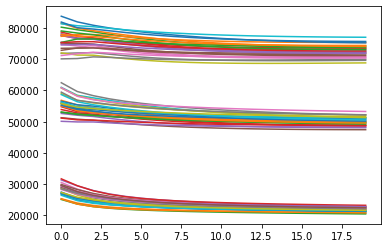

In [12]:
np.random.seed(32)
results = []

alphas = [25, 30, 35, 40]
embedding_sizes = [5, 6]
lamddas = [2, 5, 7.5]
eps = [0.07,0.11,0.15]

for alph in alphas:
    for emb_size in embedding_sizes:
        for lam in lamddas:
            for e in eps:
                print(alph, emb_size, lam, e)
                model = ImplicitALS(max_epoch=20,
                        embedding_size=emb_size,
                        alpha=alph,
                        lamdda=lam,
                        eps=e,
                        mean_decrease=0.85)
                matrix_train, matrix_valid = split_dataset(matrix, 0.1)
                res, _, _ = model.fit(matrix_train, matrix_valid)
                results.append(res)

In [13]:
# 0.91311
final_result = np.zeros(results[0].shape)
for r in results:
    final_result = final_result + r
final_result = final_result/len(results)
create_submission(final_result, 'trvalid_stacking'+str(len(results)))